In [196]:
from models import *
import numpy as np
import pandas as pd
import sqlite3
from sklearn.metrics import confusion_matrix
import plotly.express as px

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm


## Reading the Event Data and the Stock Data

In [197]:
# Connect to the SQLite database
conn = sqlite3.connect('./data-src/final_data.db')

# Replace 'your_table' with the actual table name and 'conn' with your database connection
query = 'SELECT * FROM ALL_FEATURES'

# Use the pandas read_sql function to read the data into a DataFrame
events_df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Now, you can work with the DataFrame 'df'
events_df['date'] = pd.to_datetime(events_df['date'])
events_df = events_df.sort_values(by='date')
stock_df = pd.read_csv('./data-src/stock_data.zip', compression='zip', header=[0, 1], index_col=0, parse_dates=True)


In [198]:
events_df.head()

,ticker,disease,stage,date,catalyst,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap,...,VOL_20,VOL_BVOL_20,avg_5_day_ret,std_5_day_ret,atr_10,volume_std_10,trans_std_10,prev_vol,prev_trans,NCAR_20
0,PCRX,Postsurgical pain,Approved,2011-10-31,"Approved October 31, 2011.",0.455,0.461667,-0.256693,-0.271868,4.356451e+08,...,0.057309,0.038122,-0.000519,0.037962,0.75990,167259.498603,382.814054,610058.00,1105.0,-1.041054
1,INCY,Myelofibrosis,Approved,2011-11-16,"Approved November 16, 2011.",-0.349,-1.483000,-0.260818,-1.000006,2.858325e+09,...,0.039642,0.020804,-0.003871,0.010732,0.52645,556849.398882,1825.197219,702536.00,4864.0,0.754430
2,HALO,Overactive bladder,Approved,2011-12-08,"Approved December 8, 2011.",0.341,0.791667,-0.465475,-0.425801,1.283978e+09,...,0.025458,0.015331,-0.001556,0.010211,0.40365,388706.415339,1365.249193,441988.00,2404.0,3.427405
3,CRIS,Basal Cell Carcinoma,Approved,2012-01-30,"Approved January 30, 2012.",16.200,43.900000,-4.322212,-12.690005,4.351435e+08,...,0.031528,0.019181,0.024642,0.008263,17.53000,2242.228571,842.861436,5517.65,2349.0,-2.355933
4,CORT,Cushing's Syndrome,Approved,2012-02-17,"Approved February 17, 2012.",-0.252,-0.435667,-0.199273,-0.173276,3.498192e+08,...,0.112342,0.101775,0.011668,0.044609,0.25200,419064.493780,1502.998882,1456485.00,4305.0,-0.955556


## Preparing the Return Classes and Train and Test Sets

In [199]:
def scale_X(train_X, test_X, special_exclude_cols=['catalyst', 'date', 'ticker', 'stage', 'disease']):
    sc = MinMaxScaler()
    tmp_train = train_X.loc[:, ~train_X.columns.isin(special_exclude_cols)]
    tmp_cols = train_X.columns[~train_X.columns.isin(special_exclude_cols)]

    tmp_test = test_X.loc[:, ~test_X.columns.isin(special_exclude_cols)]

    train_features_scaled = sc.fit_transform(tmp_train)
    test_features_scaled = sc.transform(tmp_test)

    train_features_scaled_df = pd.DataFrame(train_features_scaled, columns = tmp_cols)
    X_train_scaled = pd.concat([train_features_scaled_df, train_X[special_exclude_cols].reset_index(drop=True)], axis=1)

    test_features_scaled_df = pd.DataFrame(test_features_scaled, columns = tmp_cols)
    X_test_scaled = pd.concat([test_features_scaled_df, test_X[special_exclude_cols].reset_index(drop=True)], axis=1)

    return X_train_scaled, X_test_scaled


In [238]:
# Data handling, target_col is VOL_20, NCAR_20, RET_20, VOL_BVOL_20
target_col = 'NCAR_20'
exclude_cols = ['quintiles', 'NCAR_20', 'RET_20', 'VOL_20','VOL_BVOL_20']
test_size = 0.2
num_cuts = 3
dh = Data_Handler(events_df)
quintiles = dh.qcut_data(target_col, num_cuts)
dh.df['quintiles'] = quintiles
labels = [str(label) for label in quintiles.unique()].sort()
X_train, X_test, y_train, y_test = dh.train_test_split('quintiles', cols2exclude=exclude_cols, test_size=test_size)


In [239]:
X_train_scaled, X_test_scaled = scale_X(train_X=X_train, test_X=X_test)


# Transferring tabular data into graph

In [240]:
def create_graph(X, y):
    # Extract features and labels from the DataFrame
    feature_col = [i for i in X.columns if i not in exclude_cols + ['catalyst', 'date', 'ticker', 'stage', 'disease']]
    features = torch.tensor(X[feature_col].values, dtype=torch.float32)
    labels = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    # Map 'categorical' cols to indices
    # Create a DGL graph from edges and node features using vectorized operations
    catalyst_matrix = X['catalyst'].astype('category').cat.codes.values[:, None]
    ticker_matrix = X['ticker'].astype('category').cat.codes.values[:, None]
    disease_matrix = X['disease'].astype('category').cat.codes.values[:, None]
    stage_matrix = X['stage'].astype('category').cat.codes.values[:, None]
    date_matrix = pd.to_datetime(X['date']).values[:, None]

    # Create condition matrices
    ticker_condition = ticker_matrix == ticker_matrix.T
    date_condition = np.abs(date_matrix - date_matrix.T) < np.timedelta64(365, 'D')
    disease_condition = disease_matrix == disease_matrix.T
    stage_condition = stage_matrix == stage_matrix.T

    # Combine conditions to form the final condition matrix
    condition_matrix = np.logical_or(np.logical_and(ticker_condition, date_condition),
                                      np.logical_or(disease_condition, stage_condition))

    # Create edges between nodes based on shared 'ticker', 'date', 'disease', or 'stage'
    src_nodes, dst_nodes = np.where(condition_matrix & (catalyst_matrix != catalyst_matrix.T))

    src_nodes = torch.tensor(src_nodes, dtype=torch.long)
    dst_nodes = torch.tensor(dst_nodes, dtype=torch.long)

    g = dgl.graph((src_nodes, dst_nodes))
    g.ndata['features'] = features
    g.ndata['labels'] = labels

    return g


In [241]:
def plot_graph_network(g, filename):
    # Convert DGL graph to networkx graph
    nx_graph = g.to_networkx()

    # Visualize the networkx graph
    plt.figure(figsize=(16, 9))
    pos = nx.spring_layout(nx_graph)  # You can choose a different layout if needed
    nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)

    # Display the plot
    plt.savefig(filename)
    plt.show()


In [243]:
# Convert data to DGL format
train_graph = create_graph(X=X_train_scaled, y=y_train)
test_graph = create_graph(X=X_test_scaled, y=y_test)
example10_graph = create_graph(X=X_train_scaled.head(10), y=y_train.head(10))
example100_graph = create_graph(X=X_train_scaled.head(100), y=y_train.head(100))


In [244]:
print(train_graph)
print(test_graph)
print(example10_graph)
print(example100_graph)


Graph(num_nodes=1832, num_edges=735974,
      ndata_schemes={'features': Scheme(shape=(18,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=459, num_edges=36084,
      ndata_schemes={'features': Scheme(shape=(18,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=10, num_edges=90,
      ndata_schemes={'features': Scheme(shape=(18,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=100, num_edges=5382,
      ndata_schemes={'features': Scheme(shape=(18,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})


In [247]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.layer1 = dgl.nn.GraphConv(input_dim, hidden_dim)
        self.layer2 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = F.relu(self.layer2(g, x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [251]:
#  Instantiate the model
input_dim = X_train_scaled.shape[1] - 5  # Number of input features
hidden_dim = 256
output_dim = 3  # Binary classification
# model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
print(model)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


GCN(
  (layer1): GraphConv(in=18, out=256, normalization=both, activation=None)
  (layer2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [252]:
num_epochs = 1_000
losses = []

for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()
    logits = model(train_graph, train_graph.ndata['features'])

    # Use the appropriate format for multi-class labels
    labels = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train contains class indices

    # Calculate the loss using CrossEntropyLoss
    loss = criterion(logits, labels)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


Training:   0%|          | 1/1000 [00:00<09:39,  1.73epoch/s]

Epoch 1/1000, Loss: 1.0964733362197876


Training:  10%|█         | 101/1000 [00:35<04:06,  3.65epoch/s]

Epoch 101/1000, Loss: 1.086601972579956


Training:  20%|██        | 201/1000 [01:02<04:38,  2.87epoch/s]

Epoch 201/1000, Loss: 1.076674461364746


Training:  30%|███       | 301/1000 [01:35<04:02,  2.88epoch/s]

Epoch 301/1000, Loss: 1.0762220621109009


Training:  40%|████      | 401/1000 [02:04<02:35,  3.86epoch/s]

Epoch 401/1000, Loss: 1.0757590532302856


Training:  50%|█████     | 501/1000 [02:29<02:07,  3.92epoch/s]

Epoch 501/1000, Loss: 1.0752125978469849


Training:  60%|██████    | 601/1000 [02:55<01:42,  3.87epoch/s]

Epoch 601/1000, Loss: 1.0746238231658936


Training:  70%|███████   | 701/1000 [03:21<01:18,  3.79epoch/s]

Epoch 701/1000, Loss: 1.0740629434585571


Training:  80%|████████  | 801/1000 [03:47<00:50,  3.91epoch/s]

Epoch 801/1000, Loss: 1.0736074447631836


Training:  90%|█████████ | 901/1000 [04:13<00:26,  3.81epoch/s]

Epoch 901/1000, Loss: 1.0732157230377197


Training: 100%|██████████| 1000/1000 [04:39<00:00,  3.58epoch/s]


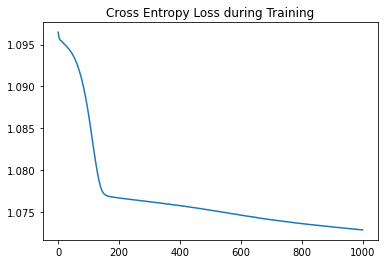

In [253]:
plt.plot(losses, label='Cross Entropy Loss')
plt.title("Cross Entropy Loss during Training")
plt.show()


In [254]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    try:
        test_logits = model(test_graph, test_graph.ndata['features'])
    except:
        test_graph_added_self_node = dgl.add_self_loop(test_graph)
        test_logits = model(test_graph_added_self_node, test_graph_added_self_node.ndata['features'])

    # For multi-class classification, use the argmax to get the predicted class
    predicted_labels = torch.argmax(test_logits, dim=1).numpy()

    # Optionally, you can calculate probabilities using softmax
    probabilities = F.softmax(test_logits, dim=1).numpy()


In [255]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [256]:
def calculate_metrics(y_test, y_prob, y_pred, model_name):
   auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='macro')
   recall = recall_score(y_test, y_pred, average='macro')
   f1 = f1_score(y_test, y_pred, average='macro')

   results = {
         'Model': model_name,
         'AUC': auc,
         'Accuracy': accuracy,
         'Precision': precision,
         'Recall': recall,
         'F1 Score': f1
   }

   return pd.Series(results)


In [257]:
print(calculate_metrics(y_test=y_test, y_prob=probabilities, y_pred=predicted_labels, model_name='GNN'))

Model             GNN
AUC          0.604229
Accuracy     0.420479
Precision    0.396026
Recall       0.402894
F1 Score     0.395811
dtype: object


# Extract Returns

In [280]:
actual_ret = events_df.iloc[-len(y_test):,16]

# Trading Strategy - GCN

In [260]:
def extract_return(y_test,actual_ret):
    positions = []
    for i in range(len(y_test)):
        if y_test[i] == 2:
            positions.append(1)
        if y_test[i] == 1:
            positions.append(0)
        if y_test[i] == 0:
            positions.append(-1)
    
    return (1 + np.array(positions)*np.array(actual_ret)).mean()

In [263]:
print(f'Average return of GCN trading strategy with NCAR prediction: {extract_return(predicted_labels,actual_ret)}')

Average return of GCN trading strategy with NCAR prediction: 0.9976688189972315


## Exploratory Analysis

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

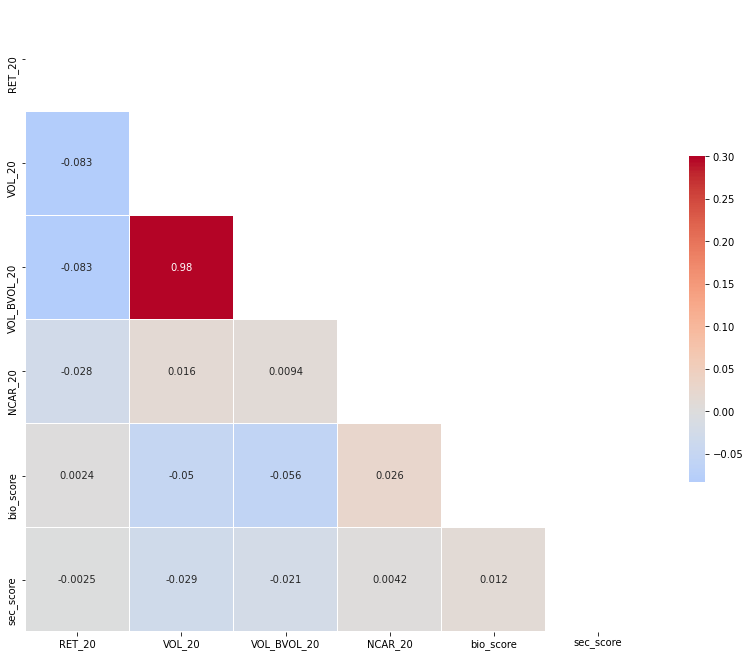

In [89]:
# Compute the correlation matrix
corr = events_df.loc[:,['RET_20','VOL_20', 'VOL_BVOL_20', 'NCAR_20',
                        'bio_score', 'sec_score'
                       ]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.show()


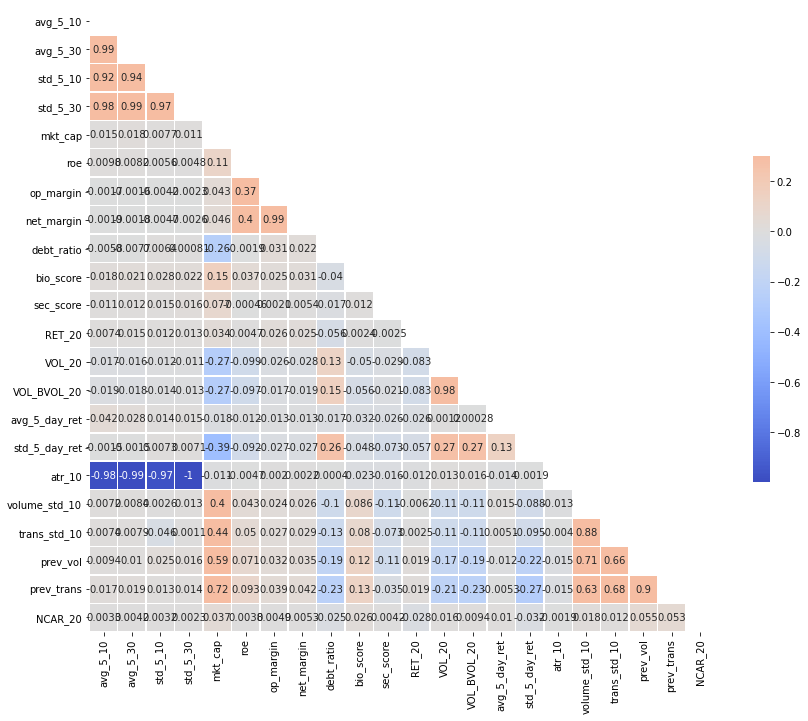

In [76]:
# Compute the correlation matrix
corr = events_df.iloc[:,5:-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.show()


## Logistic Regression

In [264]:
# Create and fit the logistic regression model
model = LR()
model.train(X_train_scaled.iloc[:, :-5], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled.iloc[:, :-5])
y_prob = model.predict_prob(X_test_scaled.iloc[:, :-5])


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [265]:
print(calculate_metrics(y_test=y_test, y_prob=y_prob, y_pred=y_pred, model_name='Logistic Regression'))


Model        Logistic Regression
AUC                     0.598038
Accuracy                0.442266
Precision               0.436652
Recall                  0.433393
F1 Score                 0.43479
dtype: object


In [227]:
# lr_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "Logistic Regression")
# model.results.print_confusion_matrix(y_test, y_pred, labels)
# model.results.plot_roc_curve(y_test, y_prob, "Logistic Regression")
# print(lr_fit_metrics)


In [266]:
print(f'Average return of LR trading strategy with NCAR prediction: {extract_return(y_pred,actual_ret)}')

Average return of LR trading strategy with NCAR prediction: 1.0008788318311341


In [96]:
trading_data = events_df.loc[X_test.index].reset_index(drop=True)
trading_data['lr_preds'] = y_pred
trading_data['lr_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
lr_portfolio = ts.buy_short('lr_signal', trading_data, stock_df, 20)


In [97]:
px.line(np.array(lr_portfolio))


## XGBoost

In [267]:
# Create and fit the XGBoost model
model = GB()
model.train(X_train_scaled.iloc[:, :-5], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled.iloc[:, :-5])
y_prob = model.predict_prob(X_test_scaled.iloc[:, :-5])


In [268]:
print(calculate_metrics(y_test=y_test, y_prob=y_prob, y_pred=y_pred, model_name='XGBoost'))


Model         XGBoost
AUC          0.599901
Accuracy     0.420479
Precision    0.404459
Recall       0.403824
F1 Score     0.402239
dtype: object


In [269]:
print(f'Average return of XGB trading strategy with NCAR prediction: {extract_return(y_pred,actual_ret)}')

Average return of XGB trading strategy with NCAR prediction: 0.9940802408950986


In [63]:
# gb_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "XGBoost Classifier")
# model.results.print_confusion_matrix(y_test, y_pred, labels)
# model.results.plot_roc_curve(y_test, y_prob, "XGBoost Classifier")
# print(gb_fit_metrics)


In [64]:
trading_data['gb_preds'] = y_pred
trading_data['gb_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
gb_portfolio = ts.buy_short('gb_signal', trading_data, stock_df, 20)


In [65]:
px.line(np.array(gb_portfolio))


## MLP Classifier

In [270]:
# Create and fit the Multi Layer Perceptron model
model = MLP()
model.train(X_train_scaled.iloc[:, :-5], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled.iloc[:, :-5])
y_prob = model.predict_prob(X_test_scaled.iloc[:, :-5])


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [271]:
print(calculate_metrics(y_test=y_test, y_prob=y_prob, y_pred=y_pred, model_name='MLP'))


Model             MLP
AUC          0.598933
Accuracy     0.442266
Precision    0.417798
Recall       0.420959
F1 Score       0.4189
dtype: object


In [272]:
print(f'Average return of MLP trading strategy with NCAR prediction: {extract_return(y_pred,actual_ret)}')

Average return of MLP trading strategy with NCAR prediction: 0.9965528102056327


In [ ]:
mlp_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "MLP Classifier")
model.results.print_confusion_matrix(y_test, y_pred, labels)
model.results.plot_roc_curve(y_test, y_prob, "MLP Classifier")
print(mlp_fit_metrics)


In [100]:
trading_data['mlp_preds'] = y_pred
trading_data['mlp_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
mlp_portfolio = ts.buy_short('mlp_signal', trading_data, stock_df, 20)


In [101]:
px.line(np.array(mlp_portfolio))


# Table of returns

In [277]:
data = {'RET_20 Prediction':['1.06%','1.07%','1.5%','0.3%'],
       'NCAR_20 Prediction':['-0.03%','0.08%','-0.06%','-0.04%']}
ret_df = pd.DataFrame(data)

new_index = ['GCN', 'LogReg', 'XGB', 'MLP']
ret_df.index = new_index


In [278]:
ret_df

,RET_20 Prediction,NCAR_20 Prediction
GCN,1.06%,-0.03%
LogReg,1.07%,0.08%
XGB,1.5%,-0.06%
MLP,0.3%,-0.04%
